In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/AN2DL/Homework1/

/gdrive/MyDrive/AN2DL/Homework1


### Import Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.8 MB/s 


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Leaf Dataset

In [ ]:
full_dataset_dir = 'full_dataset'
#!unzip dataset.zip
#os.rename('training',full_dataset_dir)

In [ ]:
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

In [ ]:
# Plot example images from dataset
num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(full_dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(full_dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### Data Preprocessing

Done in the other notebook

### Data Loader

In [ ]:
sub_dataset_dir = 'training_validation_testing'
training_dir = os.path.join(sub_dataset_dir, 'training')
validation_dir = os.path.join(sub_dataset_dir, 'validation')
test_dir = os.path.join(sub_dataset_dir, 'testing')

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale=1/255.) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 10629 images belonging to 14 classes.
Found 3547 images belonging to 14 classes.
Found 3552 images belonging to 14 classes.


In [ ]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


### Model Metadata

In [ ]:
# Model configuration
input_shape = (256, 256, 3)
epochs = 100
batch_size = 128
n_classes = 14

### CNN Model

* VGG style
* Batch Norm
* Early Stopping
* Batch
* Increasing Dropout

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout

# Model used for the exercise:
# (Conv + Conv + ReLU + MaxPool) x 3 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_10 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                      

In [ ]:
tfk.utils.plot_model(model)

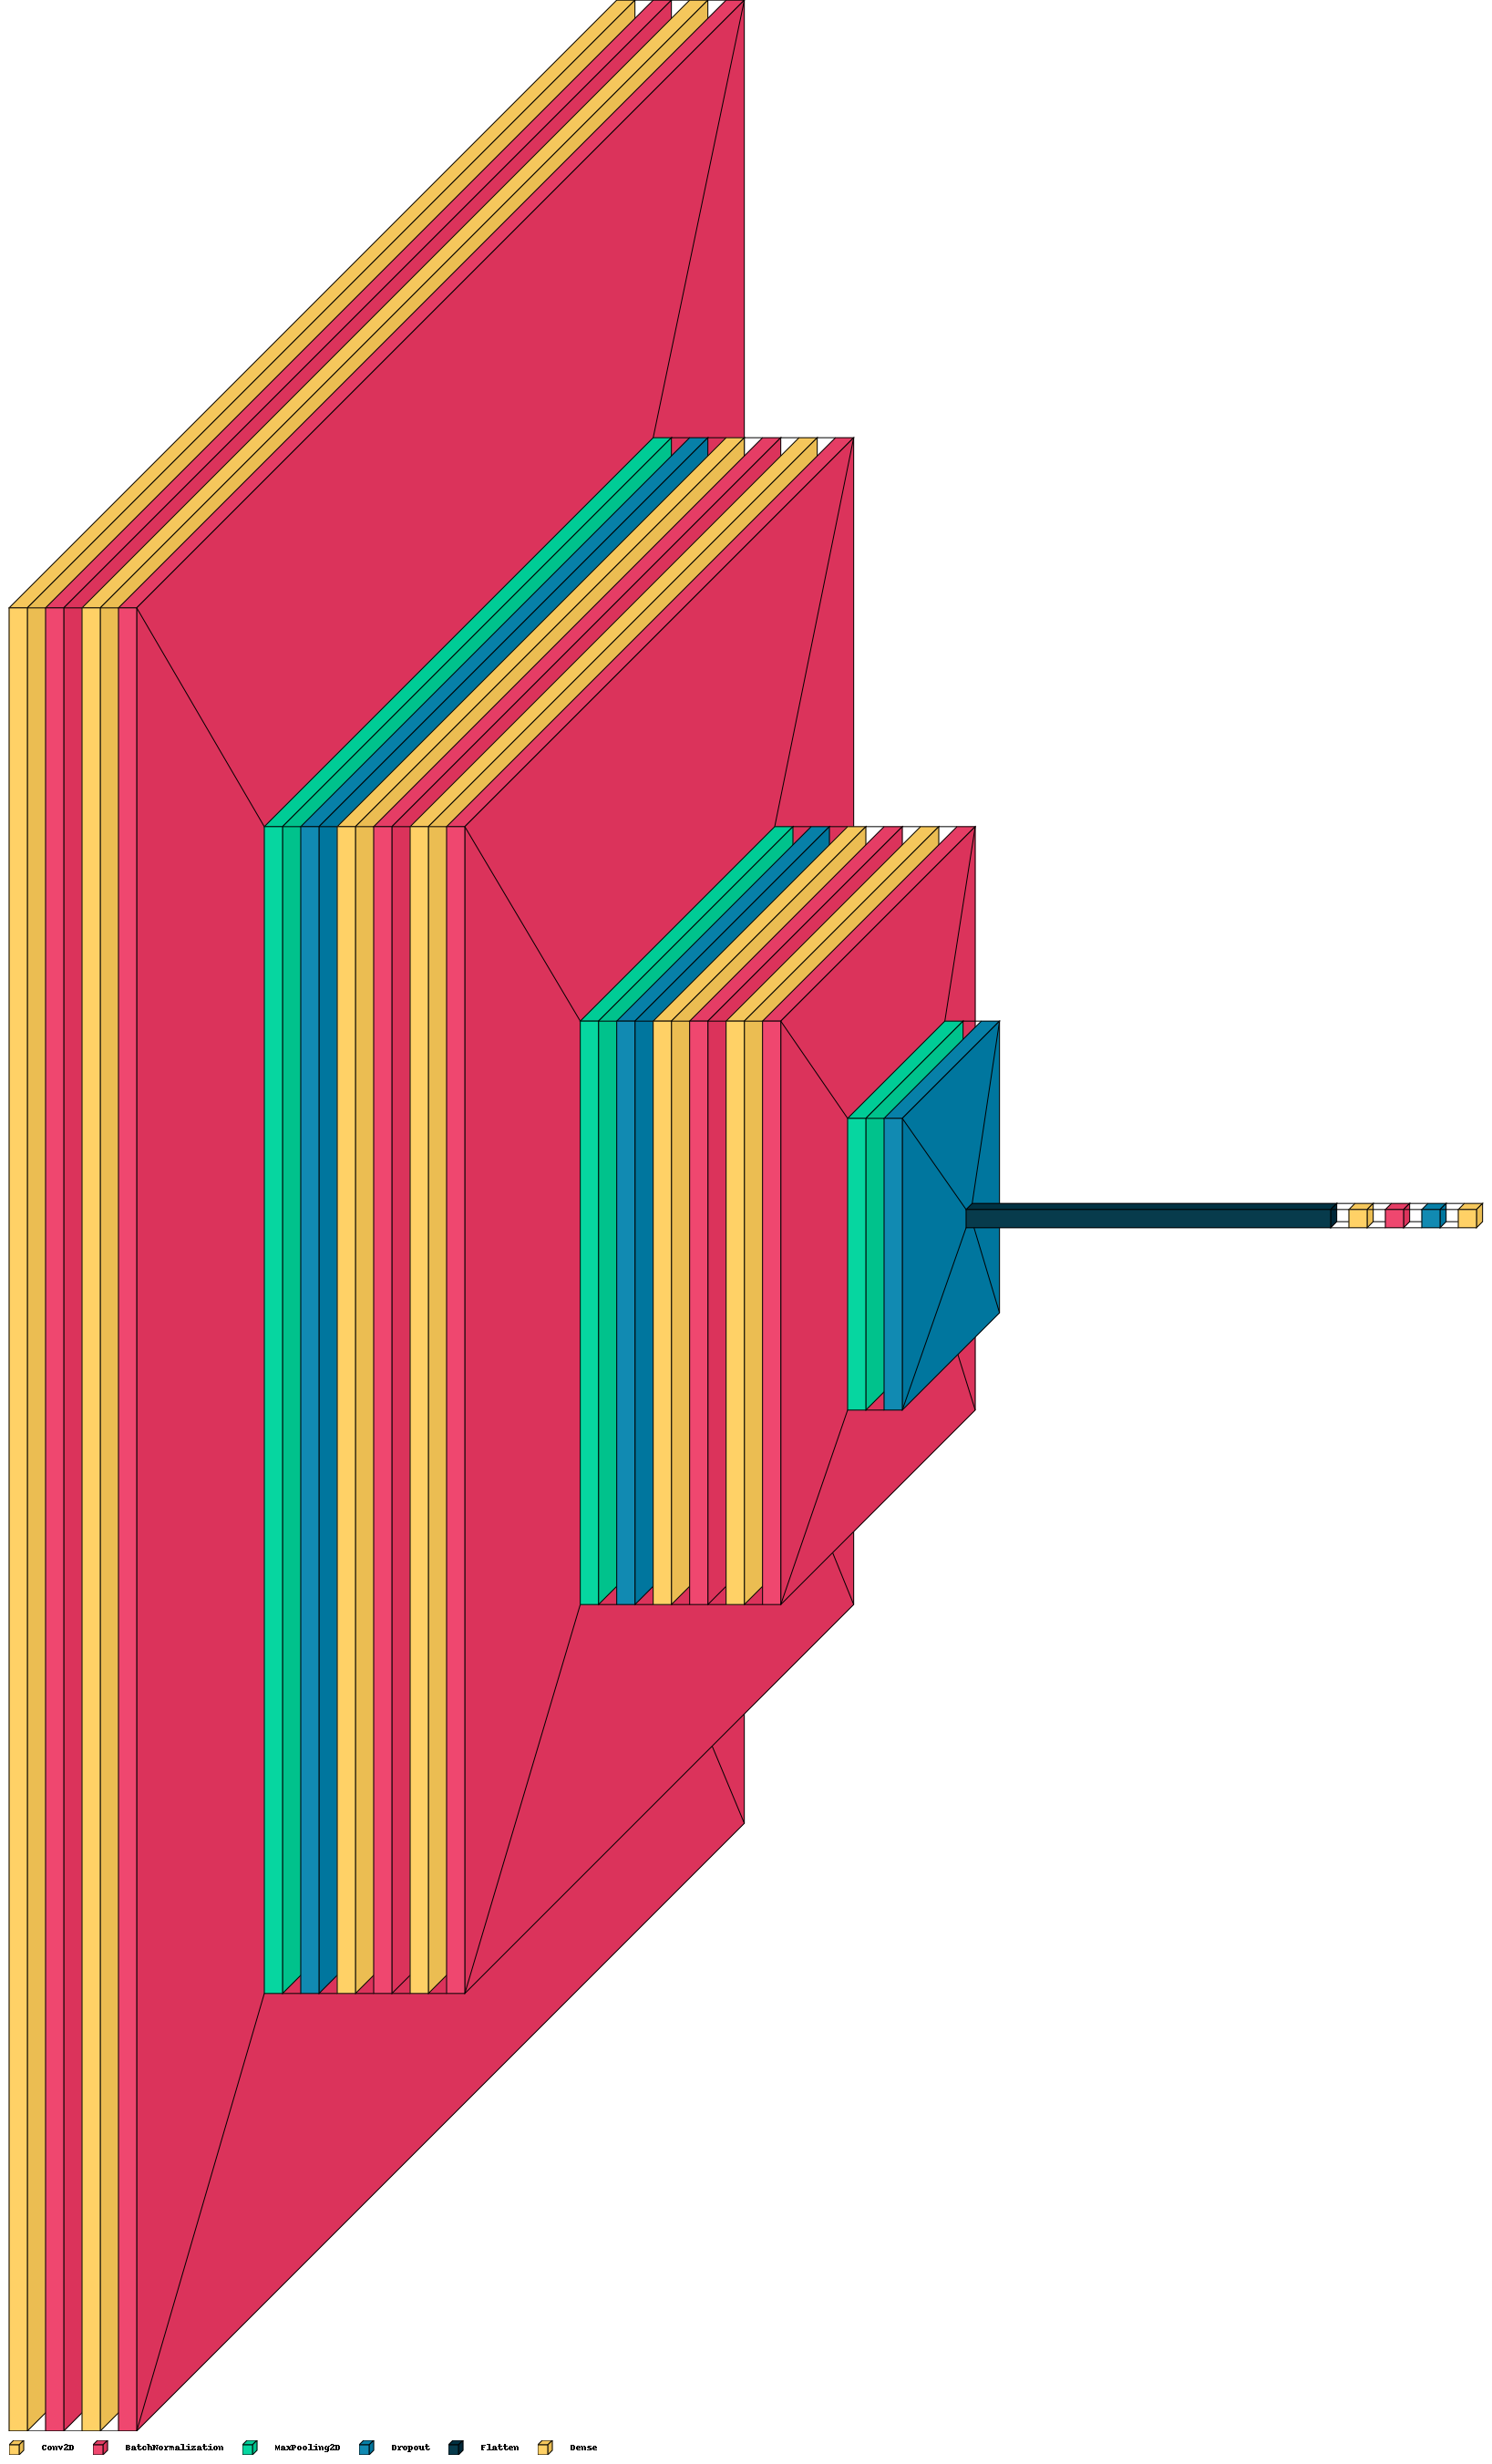

In [ ]:
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

### Training

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('models')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='CNN_full')

# Train the model
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks=[callbacks]
).history

Epoch 1/100
1329/1329 [==============================] - 205s 153ms/step - loss: 0.0517 - accuracy: 0.4567 - val_loss: 0.0743 - val_accuracy: 0.3022
Epoch 2/100
1329/1329 [==============================] - 202s 152ms/step - loss: 0.0523 - accuracy: 0.4361 - val_loss: 0.0530 - val_accuracy: 0.4584
Epoch 3/100
1329/1329 [==============================] - 201s 151ms/step - loss: 0.0462 - accuracy: 0.5137 - val_loss: 0.0361 - val_accuracy: 0.6270
Epoch 4/100
1329/1329 [==============================] - 201s 151ms/step - loss: 0.0426 - accuracy: 0.5582 - val_loss: 0.0391 - val_accuracy: 0.6095
Epoch 5/100
1329/1329 [==============================] - 201s 151ms/step - loss: 0.0389 - accuracy: 0.5958 - val_loss: 0.0349 - val_accuracy: 0.6451
Epoch 6/100
1329/1329 [==============================] - 202s 152ms/step - loss: 0.0353 - accuracy: 0.6387 - val_loss: 0.0354 - val_accuracy: 0.6425
Epoch 7/100
1329/1329 [==============================] - 252s 190ms/step - loss: 0.0354 - accuracy: 0.6382

In [ ]:
# Save best epoch model
model.save("models/CNN_full_best_" + str(datetime.now().strftime('%b%d_%H-%M-%S')))

INFO:tensorflow:Assets written to: models/CNN_full_best_Nov14_17-26-57/assets


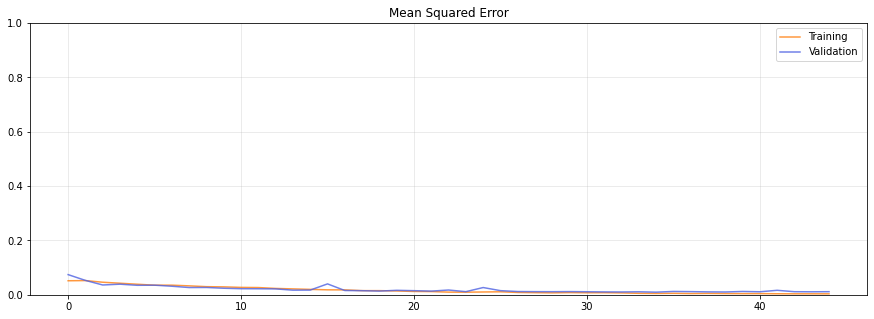

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 1)
plt.title('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(alpha=.3)

plt.show()

### Testing

In [ ]:
# Evaluate on test
# baseline
model_test_metrics = model.evaluate(test_gen, return_dict=True)

print()
print(model_test_metrics)

444/444 [==============================] - 22s 49ms/step - loss: 0.0296 - accuracy: 0.7759

{'loss': 0.029589764773845673, 'accuracy': 0.7759009003639221}


In [ ]:
# Evaluate on test
# batch norm and early stopping
model_test_metrics = model.evaluate(test_gen, return_dict=True)

print()
print(model_test_metrics)

444/444 [==============================] - 20s 46ms/step - loss: 0.0148 - accuracy: 0.8649

{'loss': 0.01480927411466837, 'accuracy': 0.8648648858070374}


In [ ]:
# Evaluate on test
# batch norm, early stopping, dropout
model_test_metrics = model.evaluate(test_gen, return_dict=True)

print()
print(model_test_metrics)

444/444 [==============================] - 60s 135ms/step - loss: 0.0102 - accuracy: 0.9071

{'loss': 0.010151666589081287, 'accuracy': 0.9070945978164673}
